In [10]:
import pandas as pd
import json
import networkx as nx
import numpy as np
import itertools
from IPython.display import clear_output
import time
import glob
from collections import Counter
from scipy.stats import spearmanr
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

# Load data

In [23]:
# load data
data_path = './data'  # change it to the path you downloaded the data to

# no_abstract_data is data w/o abstracts and up until 3/19
no_abstract_data = pd.read_json(data_path + "/arxiv-metadata-hash-abstracts-v0.2.0-2019-03-01.json", lines=True)

# metadata is all metadata from arxiv
metadata = pd.read_json(glob.glob(data_path + "/arxiv-metadata-oai-*.json")[0], lines=True)

# internal reference (arxiv only) for no_abstracts_data
with open(data_path + "/internal-references-v0.2.0-2019-03-01.json") as f:
    no_abs_internal_ref = json.load(f)

# authors parsed for no_abstracts_data
with open(data_path + "/authors-parsed-v0.2.0-2019-03-01.json") as f:
    authors_parsed = json.load(f)

# Preprocess data

In [74]:
# for each category find the super category
def super_cat(cat):
    category_to_super_category = {
        'math': 'Mathematics',
        'cs': 'Computer Science',
        'stat': 'Statistics',
        'q-bio': 'Quantitative Biology',
        'q-fin': 'Quantitative Finance',
        'eess': 'Electrical Engineering and Systems Science',
        'econ': 'Economics'
    }
    physics = 'astro-ph.GA astro-ph.CO astro-ph.EP astro-ph.HE astro-ph.IM astro-ph.SR cond-mat.dis-nn cond-mat.mtrl-sci cond-mat.mes-hall cond-mat.other cond-mat.quant-gas cond-mat.soft cond-mat.stat-mech cond-mat.str-el cond-mat.supr-con gr-qc hep-ex hep-lat hep-ph hep-th math-ph nlin.AO nlin.CG nlin.CD nlin.SI nlin.PS nucl-ex nucl-th physics.acc-ph physics.app-ph physics.ao-ph physics.atom-ph physics.atm-clus physics.bio-ph physics.chem-ph physics.class-ph physics.comp-ph physics.data-an physics.flu-dyn physics.gen-ph physics.geo-ph physics.hist-ph physics.ins-det physics.med-ph physics.optics physics.ed-ph physics.soc-ph physics.plasm-ph physics.pop-ph physics.space-ph quant-ph'

    for key in category_to_super_category.keys():
        if cat.startswith(key):
            return category_to_super_category[key]
    if cat in physics:
        return 'Physics'
    else:
        return None

def super_cats(cats):
    return set([super_cat(cat) for cat in cats[0].split()])

In [75]:
# extract year and month from id
def extract_year(s):
    if '.' in s:
        s = s.split('.')[0]
        assert len(s) == 4
        s = s[:2]
    elif '/' in s:
        s = s.split('/')[1]
        assert len(s) == 7
        s = s[:2]
    else:
        raise Exception(s)
    s = int(s)
    if s >= 90:
        s += 1900
    else:
        s += 2000
    return s

def extract_month(s):
    if '.' in s:
        s = s.split('.')[0]
        assert len(s) == 4
        s = s[2:]
    elif '/' in s:
        s = s.split('/')[1]
        assert len(s) == 7
        s = s[2:4]
    else:
        raise Exception(s)
    return s


no_abstract_data['year'] = no_abstract_data['id'].apply(extract_year)
no_abstract_data['month'] = no_abstract_data['id'].apply(extract_month)

In [76]:
metadata['super_categories'] = metadata.categories.apply(super_cats)
metadata['year'] = metadata['id'].apply(extract_year)
metadata['month'] = metadata['id'].apply(extract_month)

# Create an animation of Venn Diagrams of the interactions between the categories, evoloving over the years.

In [77]:
# all super categories
categories = ['Mathematics', 'Computer Science', 'Statistics', 'Quantitative Biology',
              'Quantitative Finance', 'Electrical Engineering and Systems Science',
              'Economics', 'Physics']

# dummy column for each category
for category in categories:
    metadata[category] = metadata['super_categories'].apply(lambda x: category in x)
    
# relevant columns set boolean to produce the venn diagram
m = metadata[categories + ['year']].astype(int)  
    
# create a df for each year, and dump to files (that will be processed in R)
for year, df_y in m.groupby('year').groups.items():
    x = m.loc[df_y][[
        'Mathematics',
        'Computer Science',
        'Statistics',
        'Quantitative Biology',
        'Quantitative Finance',
        'Electrical Engineering and Systems Science'
    ]]
    columns = []
    for col in x.columns:
        if x[col].sum() > 0:
            columns.append(col)
    x = x[columns]
    x.to_csv(str(year) + '_metadata.csv', index=False)

In [78]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [102]:
%%R
# Creating Venn diagram for more than 3 groups is problematic in Python, but easy in R.
# So here's the R snippet we've used to create the diagrams.

install.packages("eulerr")
library(eulerr)

# colors to category
colors <- c("darkolivegreen1", "#FFB6DB", "#B66DFF", "#6DB6FF", "#009292", "indianred1")
names(colors) <- c("Mathematics","Computer.Science","Statistics","Quantitative.Biology","Quantitative.Finance","Electrical.Engineering.and.Systems.Science")

years = c(1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)

# plot the venn diagram and save as jpg
for (year in years) {
    df = read.csv(sprintf("%d_metadata.csv",year))
    dev.new()
    png(sprintf("venn_%d.jpg",year))
    res <- plot(euler(df),
                main=sprintf("venn_%d",year),
                counts = T,
                fontface = 1,
                fills = list(fill = colors[colnames(df)], alpha = 0.7),
                quantities = list(cex = .5),
                legend = list(labels = colnames(df) ))
    print(res)
    dev.off()
}

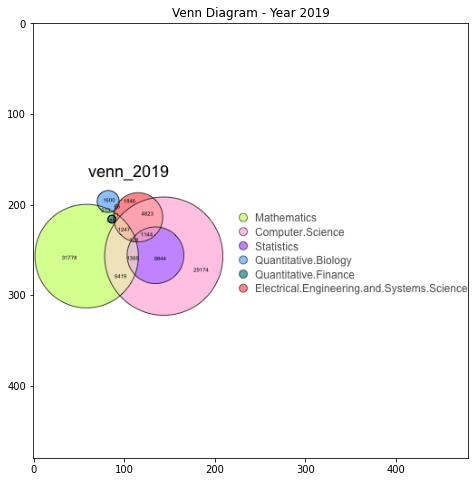

In [80]:
# display animation of the Venn diagrams
delay = 0.1

images = {year: plt.imread('venn_%d.jpg' % year)
          for year in sorted(no_abstract_data['year'].unique())}

for year, image in images.items():
    clear_output(wait=True)
    plt.figure(figsize=(8, 8))
    plt.title('Venn Diagram - Year ' + str(year))
    plt.imshow(image)
    plt.show() 
    time.sleep(delay)

In [81]:
# find only cs articles in the hash-abstract data

def is_cs(x):
    if x[0].startswith("cs.") or " cs." in x[0]: 
            return True
    return False
                                           

no_abstract_data["is_CS"] = no_abstract_data.categories.apply(is_cs)
cs_data = no_abstract_data[no_abstract_data["is_CS"]]

In [82]:
# get rid of empty references

no_abs_internal_ref = {key: value
                       for key, value in no_abs_internal_ref.items()
                       if len(value) > 0}

# merge data of authors and reference to cs_data and organizing data, getting rid of irrelevant columns

ref_updated_df = pd.Series(no_abs_internal_ref,index=no_abs_internal_ref.keys()).to_frame()
authors_parsed_df = pd.Series(authors_parsed,index=authors_parsed.keys()).to_frame()
cs_with_citations = cs_data.merge(ref_updated_df, "left", right_index=True, left_on="id")
cs_with_citations.rename({0:'citations'}, axis=1, inplace=True)
cs_with_citations = cs_with_citations.merge(authors_parsed_df, "left", right_index=True, left_on="id")
cs_with_citations.rename({0:'authors_parsed'}, axis=1, inplace=True)


cs_with_citations.drop(columns=['submitter','versions','is_CS'], inplace=True)

In [83]:
# convert categories to a list we can work with 

assert (cs_with_citations.categories.map(len) == 1).all()
cs_with_citations['categories'] = cs_with_citations.categories.apply(lambda y: y[0].split())

In [84]:
# adding useful columns to the data: authors_names, authors_institutions (if mentioned)

def extract_name(author):
    name = " ".join(author[:3]).strip().lower().replace(".","").replace(",","")
    if len(name) > 2:
        return name
    return None
    

def extract_names(authors):
    return list(filter(None, [extract_name(author) for author in authors]))


cs_with_citations['authors_names'] = cs_with_citations['authors_parsed'].apply(extract_names)

In [85]:
# parse citations in df to a format we can work with
cs_with_citations['citations'] = cs_with_citations['citations'].apply(
    lambda l: l if isinstance(l, list) else [])

In [86]:
# finding the in-citations for each article, and number of in-citations

citations_dict = {}

def update_citations_dict(row):
    for item in row['citations']:
        if item not in citations_dict:
            citations_dict[item] = []
        citations_dict[item].append(row['id'])


cs_with_citations.apply(update_citations_dict, axis=1)
cs_with_citations['in-citations'] = cs_with_citations.id.map(lambda x: citations_dict.get(x, []))
cs_with_citations['num_in-citations'] = cs_with_citations['in-citations'].map(len)

# Use Gephi to visualize a graph of interactions between categories

In [87]:
# create undirected weighted graph, where each node is a category, and
# there's an edge between two categories weighted according to the number
# of papers that belong to these categories.

categories_coop_counter = Counter()

def update_categories_coop_counter(categories):
    cats = filter(lambda x: x.startswith('cs'), categories)
    for x,y in itertools.combinations(cats, 2):
        categories_coop_counter[(x, y)] += 1

cs_with_citations['categories'].apply(update_categories_coop_counter)
categories_coop_g = nx.Graph()
categories_coop_g.add_edges_from([[categories[0], categories[1], {'weight': weight}]
                                  for categories, weight in categories_coop_counter.items()])
nx.write_gexf(categories_coop_g, "cat_coops.gexf", encoding='utf-8', prettyprint=True, version='1.1draft')

In [88]:
cs_fields = {   'cs.AI': 'Artificial Intelligence',
                'cs.CL': 'Computation and Language',
                'cs.CC': 'Computational Complexity',
                'cs.CE': 'Computational Engineering, Finance, and Science',
                'cs.CG': 'Computational Geometry' ,
                'cs.GT': 'Computer Science and Game Theory', 
                'cs.CV': 'Computer Vision and Pattern Recognition', 
                'cs.CY': 'Computers and Society', 
                'cs.CR': 'Cryptography and Security', 
                'cs.DS': 'Data Structures and Algorithms', 
                'cs.DB': 'Databases', 
                'cs.DL': 'Digital Libraries', 
                'cs.DM': 'Discrete Mathematics', 
                'cs.DC': 'Distributed, Parallel, and Cluster Computing', 
                'cs.ET': 'Emerging Technologies', 
                'cs.FL': 'Formal Languages and Automata Theory', 
                'cs.GL': 'General Literature', 
                'cs.GR': 'Graphics', 
                'cs.AR': 'Hardware Architecture',
                'cs.HC': 'Human-Computer Interaction', 
                'cs.IR': 'Information Retrieval', 
                'cs.IT': 'Information Theory', 
                'cs.LG': 'Learning', 
                'cs.LO': 'Logic in Computer Science', 
                'cs.MS': 'Mathematical Software', 
                'cs.MA': 'Multiagent Systems', 
                'cs.MM': 'Multimedia',
                'cs.NI': 'Networking and Internet Architecture',
                'cs.NE': 'Neural and Evolutionary Computing',
                'cs.NA': 'Numerical Analysis',
                'cs.OS': 'Operating Systems',
                'cs.OH': 'Other Computer Science',
                'cs.PF': 'Performance',
                'cs.PL': 'Programming Languages',
                'cs.RO': 'Robotics',
                'cs.SI': 'Social and Information Networks',
                'cs.SE': 'Software Engineering',
                'cs.SD': 'Sound',
                'cs.SC': 'Symbolic Computation',
                'cs.SY': 'Systems and Control'
            }
for field in cs_fields:
    cs_with_citations["is_" + field] = cs_with_citations['categories'].map(lambda x: field in x)

# Create a stackplot of number of submissions in categories of cs in the years 1998-2018

In [89]:
def stackplot(yr_category_cs_pivot, normalize, file_name, title):
    yr_category_cs_pivot = yr_category_cs_pivot.sort_values(yr_category_cs_pivot.index.max(),
                                                            axis=1,
                                                            ascending=False)
    yr_category_cs_pivot = yr_category_cs_pivot.rename(columns={
        col: col.split('_')[1] for col in cs_fields_columns
    })
    
    if normalize:
        yr_category_cs_pivot = yr_category_cs_pivot.divide(
            yr_category_cs_pivot.sum(axis=1),
            axis=0
        )
    plt.figure(figsize=(15, 12))
    plt.stackplot(yr_category_cs_pivot.index,
                  yr_category_cs_pivot.T,
                  labels=map(cs_fields.get,
                            yr_category_cs_pivot.columns))
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.title(title)
    plt.xlabel("year")
    plt.ylabel("amount of submissions in sub-field (normalized)")
    plt.savefig(file_name + '.png')

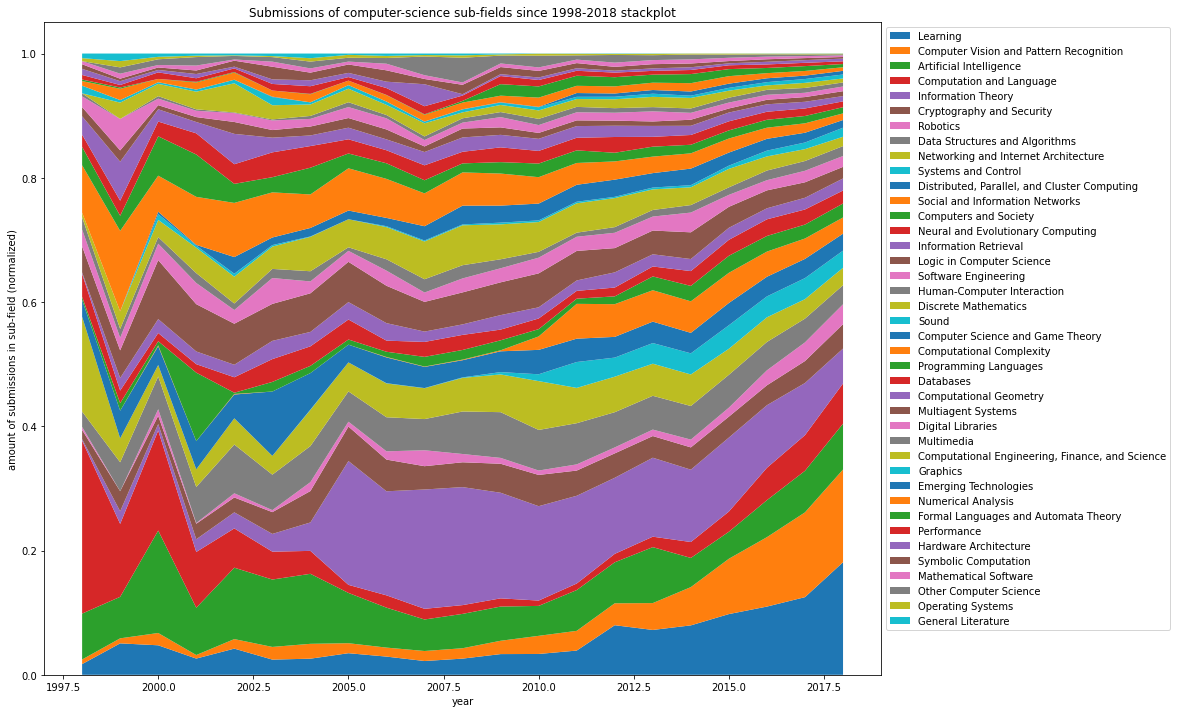

In [90]:
cs_fields_columns = ["is_" + field for field in cs_fields]
agg_functions = {col : 'sum' for col in cs_fields_columns}
cs_category_yr = cs_with_citations.groupby('year').agg(agg_functions)
stackplot(cs_category_yr.iloc[5:-1], normalize=True, file_name='cs_stackplot',
          title="Submissions of computer-science sub-fields since 1998-2018 stackplot")

# Number of submissions per year

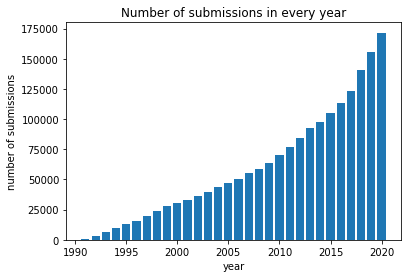

In [91]:
plt.bar(metadata['year'].value_counts().index, metadata['year'].value_counts())
plt.title("Number of submissions in every year")
plt.xlabel("year")
plt.ylabel("number of submissions")
plt.savefig('number_of_submissions_per_year.png')

# Visualize the popluarity of arxiv over time

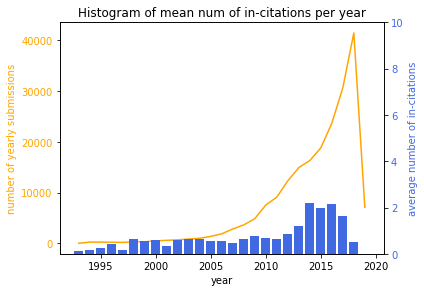

In [92]:
# create a histogram of mean sum of in-citations per articles that were published in a year.
# to understand the bigger context, also draw a line plot of the number of submissions
# per year. Note both will share the same figure, but each will have a differenty axis.
fig, ax1 = plt.subplots()

color = 'orange'
ax1.set_xlabel('year')
ax1.set_ylabel('number of yearly submissions', color=color)
yearly_submissions = cs_with_citations['year'].value_counts().sort_index()
ax1.plot(yearly_submissions.index, yearly_submissions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'royalblue'
ax2.set_ylabel('average number of in-citations', color=color)
yearly_mean_in_citations = cs_with_citations.groupby('year')['num_in-citations'].mean()
ax2.bar(yearly_mean_in_citations.index, yearly_mean_in_citations, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.ylim((0, 10))

fig.tight_layout()
plt.title('Histogram of mean num of in-citations per year')

fig.savefig("hist_of_mean_sum_in_citations.png")

In [93]:
# filter only the papers that belong to Machine Learning categories

ml_fields = {
    'cs.AI': 'Artificial Intelligence',
    'cs.CL': 'Computation and Language',
    'cs.CV': 'Computer Vision and Pattern Recognition',
    'cs.LG': 'Learning',
    'cs.NE': 'Neural and Evolutionary Computing',
    'cs.RO': 'Robotics',
    'cs.SD': 'Sound'
}

ml_df = cs_with_citations[cs_with_citations['is_cs.AI'] | cs_with_citations['is_cs.CL'] |
                          cs_with_citations['is_cs.CV'] | cs_with_citations['is_cs.LG'] | 
                          cs_with_citations['is_cs.NE'] | cs_with_citations['is_cs.RO'] | 
                          cs_with_citations['is_cs.SD']]

# Calculate normalized pagerank over the citations graph (inspired by the paper [ranking in evolving complex networks](https://arxiv.org/abs/1704.08027))

In [94]:
# create a directed graph where each node is a paper, and there's an edge
# between two papers if the first paper cites the second paper.
ml_citations_dict = ml_df[['id', 'citations']].set_index('id').to_dict()
ml_citations_edges = []
for key, vals in ml_citations_dict['citations'].items():
    if vals:
        for val in vals:
            ml_citations_edges.append([key, val])
            
ml_citations_graph = nx.DiGraph()
ml_citations_graph.add_edges_from(ml_citations_edges)
nx.write_gexf(ml_citations_graph, "ml_citations_graph.gexf", encoding='utf-8', prettyprint=True)

In [95]:
# calculate PageRank on the citations graph.
# In addition, since there's a bias to old papers (since a paper can only cite older
# papers), we aleviate the bias by normalizing the PageRank scores according to
# windows of size 1000.
pr = nx.pagerank(ml_citations_graph)
pr_df = ml_df.merge(pd.Series(pr, name='pr'), how='inner', left_on='id', right_index=True)
pr_df = pr_df.sort_values(['year', 'month']).reset_index(drop=True) 

window = 1000


def normalize_rank(ranks):
    loc = int(window / 2)
    if len(ranks) < window and 0 in ranks.index:
        loc = -loc - (window % 2)
            
    curr_rank = ranks.iloc[loc]
    return (curr_rank - np.mean(ranks)) / np.std(ranks)


pr_df['normalized_pr'] = pr_df[['pr']].rolling(window=window,
                                               min_periods=0,
                                               center=True).apply(normalize_rank)

In [96]:
pr_df['pr_index'] = pr_df['pr'].rank(ascending=False)
pr_df['normalized_pr_index'] = pr_df['normalized_pr'].rank(ascending=False)

In [105]:
# show the top 10
pr_df.sort_values('normalized_pr_index')[['id', 'authors', 'title', 'pr', 'normalized_pr']].iloc[:10]

,id,authors,title,pr,normalized_pr
5614,1412.6980,Diederik P. Kingma and Jimmy Ba,Adam: A Method for Stochastic Optimization,0.010409,27.480684
2143,1207.0580,"Geoffrey E. Hinton, Nitish Srivastava, Alex Kr...",Improving neural networks by preventing co-ada...,0.025293,27.281768
1412,1108.3298,"Byron Knoll, Nando de Freitas",A Machine Learning Perspective on Predictive C...,0.007320,26.445150
721,0902.1284,"Daniel Hsu, Sham M. Kakade, John Langford, Ton...",Multi-Label Prediction via Compressed Sensing,0.003005,26.046207
4884,1409.1556,"Karen Simonyan, Andrew Zisserman",Very Deep Convolutional Networks for Large-Sca...,0.016077,25.778525
8893,1512.03385,"Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun",Deep Residual Learning for Image Recognition,0.002976,24.031351
38207,1810.04805,"Jacob Devlin, Ming-Wei Chang, Kenton Lee, and ...",BERT: Pre-training of Deep Bidirectional Trans...,0.000051,23.573560
9932,1603.04467,"Mart\'in Abadi, Ashish Agarwal, Paul Barham, E...",TensorFlow: Large-Scale Machine Learning on He...,0.001701,23.523644
17763,1704.04861,"Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitr...",MobileNets: Efficient Convolutional Neural Net...,0.000607,22.707429
15689,1701.07875,"Martin Arjovsky, Soumith Chintala, L\'eon Bottou",Wasserstein GAN,0.000773,22.685950


In [98]:
# let's calculate the correlation between the PageRank,
# normalized PageRank, time, and number of citations

def calc_corr(pr_df):
    pr_df = pr_df[['pr', 'normalized_pr', 'num_in-citations']].reset_index().dropna()
    print(spearmanr(pr_df.index, pr_df['pr']))
    print(spearmanr(pr_df.index, pr_df['normalized_pr']))
    print(spearmanr(pr_df['num_in-citations'], pr_df['pr']))
    print(spearmanr(pr_df['num_in-citations'], pr_df['normalized_pr']))
    
calc_corr(pr_df)

SpearmanrResult(correlation=-0.4477130880815941, pvalue=0.0)
SpearmanrResult(correlation=-0.19125570864924848, pvalue=0.0)
SpearmanrResult(correlation=0.9414744955031812, pvalue=0.0)
SpearmanrResult(correlation=0.6818587954248072, pvalue=0.0)


# Find sleeping beauties
####  A "Sleeping Beauty in Science" is a publication that goes unnoticed ("sleeps") for a long time and then, almost suddenly, attracts a lot of attention ("is awakened by a prince")

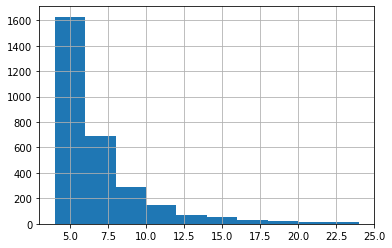

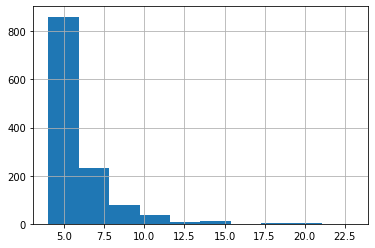

array([['physics/0004057',
        'Naftali Tishby (Hebrew University and NEC Research Institute),\n  Fernando C. Pereira (ATT Shannon Laboratory), and William Bialek (NEC\n  Research Institute)',
        'The information bottleneck method', '04', 2000, 765.0, 249.0],
       ['cmp-lg/9709008',
        'Jay J. Jiang (University of Waterloo), David W. Conrath (McMaster\n  University)',
        'Semantic Similarity Based on Corpus Statistics and Lexical Taxonomy',
        '09', 1997, 1326.0, 773.0],
       ['cmp-lg/9511007', 'Philip Resnik',
        'Using Information Content to Evaluate Semantic Similarity in a Taxonomy',
        '11', 1995, 3633.0, 3679.0],
       ['cs/0609058',
        'Ralf Steinberger, Bruno Pouliquen, Anna Widiger, Camelia Ignat, Tomaz\n  Erjavec, Dan Tufis, Daniel Varga',
        'The JRC-Acquis: A multilingual aligned parallel corpus with 20+\n  languages',
        '09', 2006, 1867.0, 5556.0],
       ['cs/0211004',
        'Nicola Leone, Gerald Pfeifer, Wolfgang F

In [99]:
def cit_year(x):
    if x:
        return [extract_year(y) for y in x]

cs_with_citations['in-citations_yrs'] = cs_with_citations['in-citations'].apply(cit_year)

def find_interval(x):
    if x is not None:
        x.sort()
        interval = 0
        for i in range(len(x)-1):
            if np.abs(x[i+1] - x[i]) > interval:
                interval = np.abs(int(x[i+1]) - int(x[i]))
        return interval
    return 0

def interval_cit_year(row):
    if row['in-citations_yrs'] is not None:
        x = sorted(row['in-citations_yrs'])
        return x[0] - row['year']
    return 0

# show histograms of max intervals between citations 
cs_with_citations['interval_cit_yrs'] =cs_with_citations.apply(interval_cit_year, axis=1)
cs_with_citations[cs_with_citations['interval_cit_yrs'] > 3]['interval_cit_yrs'].hist()
plt.show()

# show histograms of intervals between publication and first citation 
cs_with_citations['article_to_cit_interval'] = cs_with_citations['in-citations_yrs'].map(find_interval)
cs_with_citations[cs_with_citations['article_to_cit_interval'] > 3]['article_to_cit_interval'].hist()
plt.show()

# combine all the searching criteria, in order ro find sleeping beauties, i.e. - papers
# with at least 6 citations, and a gap of 10 years without any citations
in_cit_int = cs_with_citations.apply(interval_cit_year, axis=1) > 9
publ_to_cit_int = cs_with_citations['in-citations_yrs'].map(find_interval) > 9
num_cit_threshold = cs_with_citations['num_in-citations'] > 5
in_ml = cs_with_citations['categories'].apply(lambda x: any([y in ml_fields.keys() for y in x]))
sleeping_beauties = cs_with_citations[(in_cit_int | publ_to_cit_int) &
                                      num_cit_threshold &
                                      in_ml][['id','authors', 'title', 'month', 'year']].merge(
    pr_df[['id', 'pr_index', 'normalized_pr_index']], 'left', on='id'
)
sleeping_beauties.sort_values('normalized_pr_index').iloc[:10].values

# Build a simple recommender, that given a list of papers, recommends related papers for reading.

In [100]:
def rank_relevant_papers(papers, max_distance=3, max_recommendations=3):
    """
    Given a list of papers, recommend more papers that should be read in order to understand
    the input papers.
    The algorithm works by traversing the citation graph from the given input papers.
    Then, for each paper that can be reached from at least two papers in the input,
    calculate the reciprocal of its average distance from each pair of the input papers,
    and sum over all pairs. The result number will be the rank of the paper.
    Finally, return top papers.
    """
    ancestor_groups = [nx.single_source_shortest_path_length(ml_citations_graph,
                                                             paper,
                                                             cutoff=max_distance)
                 for paper in papers]
    ancestors = list(set(sum([list(g.keys()) for g in ancestor_groups], [])))

    ancestor_to_score = {}
    for ancestor in ancestors:
        ancestor_scores = []
        for g1, g2 in itertools.combinations(ancestor_groups, 2):
            mean_dist = np.mean([g1.get(ancestor, np.inf), g2.get(ancestor, np.inf)])
            ancestor_scores.append(1. / mean_dist)
        ancestor_to_score[ancestor] = np.mean(ancestor_scores)

    res = [(ancestor, score) for ancestor, score in ancestor_to_score.items()]
    res = sorted(res, key=lambda ancestor_and_score: ancestor_and_score[1], reverse=True)
    res = [(ancestor, score) for ancestor, score in res if ancestor not in papers and score > 0]
    return pd.DataFrame(res, columns=['id', 'score']).merge(ml_df, how='left', left_on='id', right_on='id')[:max_recommendations]


def sample_papers_with_word_in_title(word, n):
    """
    A util function that helps searching for papers in the same field (by searching for
    the given word in the abstract).
    """
    df = ml_df[ml_df.title.str.lower().str.contains(word.lower()) &
               ml_df['in-citations'].astype(bool)][['id', 'title']]
    return df.sample(n=n, replace=False)


papers = sample_papers_with_word_in_title('cnn', 2)
print('--- Query:\n\n', '\n\n'.join(papers['title']))
res = rank_relevant_papers(papers.id.values)
print('\n\n--- Ranked papers:\n\n', '\n\n')
for i in range(len(res)):
    r = res.iloc[i]
    print(r['score'], ':', r['title'], '\n')

--- Query:

 TI-CNN: Convolutional Neural Networks for Fake News Detection

Systematic evaluation of CNN advances on the ImageNet


--- Ranked papers:

 


1.0 : Unsupervised Representation Learning with Deep Convolutional Generative
  Adversarial Networks 

0.6666666666666666 : Batch Normalization: Accelerating Deep Network Training by Reducing
  Internal Covariate Shift 

0.6666666666666666 : Empirical Evaluation of Rectified Activations in Convolutional Network 



# Identify important authors by running pagerank over the graph of citatations between authors

In [101]:
# Create a weighted graph of authors, where the edge between two authors is weighted
# according to the number of times the first author has cited a paper co-authored
# by the second author. Then, calculate PageRank in order to identify the authors
# with the highest rank.

ml_df_by_id = ml_df.set_index('id')
author_citation_counter = Counter()

for source, target in tqdm(ml_citations_edges):
    for source_author in ml_df_by_id.loc[source]['authors_names']:
        try:
            for target_author in ml_df_by_id.loc[target]['authors_names']:
                author_citation_counter[(source_author, target_author)] += 1
        except:
            pass
        
authors_citation_g = nx.Graph()
authors_citation_g.add_edges_from([[authors[0], authors[1], {'weight': weight}]
                                   for authors, weight in author_citation_counter.items()])

authors_pr = nx.pagerank(authors_citation_g)
authors_pr_list = sorted(authors_pr.items(), key=lambda x: x[1], reverse=True)

list(enumerate(authors_pr_list))[:100]

100%|██████████| 187183/187183 [02:37<00:00, 1188.34it/s]


[(0, ('bengio yoshua', 0.003998547120388762)),
 (1, ('kingma diederik p', 0.003929716088405185)),
 (2, ('simonyan karen', 0.003548894515647402)),
 (3, ('ba jimmy', 0.003360292071366971)),
 (4, ('zisserman andrew', 0.0032640981274883202)),
 (5, ('cho kyunghyun', 0.0023721690543029054)),
 (6, ('vinyals oriol', 0.0022953919678409757)),
 (7, ('szegedy christian', 0.002006494295875637)),
 (8, ('sutskever ilya', 0.0018978306188382034)),
 (9, ('goodfellow ian', 0.001743146204269136)),
 (10, ('darrell trevor', 0.0015739956870660864)),
 (11, ('dean jeffrey', 0.0015472837367308525)),
 (12, ('bahdanau dzmitry', 0.0015261240128795301)),
 (13, ('girshick ross', 0.001466957416865028)),
 (14, ('mikolov tomas', 0.0014647666210490838)),
 (15, ('jia yangqing', 0.0014611365113047325)),
 (16, ('he kaiming', 0.0014386109711260068)),
 (17, ('kavukcuoglu koray', 0.0013016987757504576)),
 (18, ('courville aaron', 0.0012987490033834197)),
 (19, ('graves alex', 0.001292169437181114)),
 (20, ('shlens jonathon', 